In [1]:
import feather
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

from numba import jit

from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, hstack

from ml_toolbox.xgboostmonitor_utils import *
import ml_toolbox.xgboostmonitor_utils as xgbm

%matplotlib inline

import xgboost as xgb
import subprocess

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Custom modules
import const
import func

## Load data

In [2]:
y = func.read_last_column(os.path.join(const.BASE_PATH,const.TRAIN_FILES[0]+'.csv'))
print y.head(3)
y = y.Response.values

    Response
Id          
4          0
6          0
7          0


In [3]:
# Load columns name
num_cols = func.get_columns_csv(os.path.join(const.BASE_PATH, const.TRAIN_FILES[0]))[:200]

In [51]:
train_stack = feather.read_dataframe('divers/tr_stack1.feather')
#test_stack = feather.read_dataframe('divers/te_stack1.feather')
#tr_lauren = feather.read_dataframe('../input/tr_lauren.feather')
#te_lauren = feather.read_dataframe('../input/te_lauren.feather')

#leak = pd.read_csv('../input/leak_feature.csv')
tr_feather_set1 = feather.read_dataframe('divers/train.feather')
#te_feather_set1 = pd.read_csv('divers/test_eng.csv')
tr_feather_set1.columns = [x + '_v2' for x in tr_feather_set1.columns]
train = pd.concat([train_stack,tr_feather_set1],axis = 1)

In [47]:
set(train_stack.columns) & set(tr_feather_set1.columns)

set()

In [48]:
features = list(train.columns)
features.remove("Y")
#features.remove("Id")
#features.remove("Id")
features.remove("Response")
#features.remove("tdeltadevrel_block1a")
features.remove("cluster_n500")
features.remove("unique_path")
features.remove('magic3')
features.remove('magic4')

ValueError: list.remove(x): x not in list

In [52]:
X = train[features]

In [53]:
del train_stack,tr_feather_set1,train
import gc
gc.collect()

40

In [54]:
print('X_num_raw: {}'.format(X.shape))

X_num_raw: (1183747, 152)


In [55]:
print const.CV
with open(const.CV, 'rb') as f:
    cv = pickle.load(f)
n_cv = len(cv)

/Users/joostbloom/Documents/kaggle/bosch/data/folds_V1.pkl


In [56]:
n_cv

5

In [57]:
x_train = xgb.DMatrix(X, 
                      label=y)

## Train simple model

In [67]:
def score_xgboost_full(params):
    
    global counter
    
    #print ('Params testing %d: %s' % (counter, params))
    counter += 1
    
    print('Predicting XGBoost score with ({}):'.format(counter))
    print('\t {} samples'.format(x_train.num_row()))
    print('\t {} features'.format(x_train.num_col()))
    print('\t {} parameters'.format(params))
    
    preds_val = np.zeros(y.shape)
    
    for (itrain, ival) in cv:
    
        x_tr = x_train.slice(itrain)
        x_va = x_train.slice(ival)

        watchlist = [ (x_tr, 'train'), (x_va, 'eval')]

        eval_result = {}

        bst = xgb.train(params, 
                        x_tr, 
                        num_boost_round=params['num_round'], 
                        evals=watchlist,
                        evals_result=eval_result,
                        early_stopping_rounds=params['early_stopping'],
                        verbose_eval=5)

        #print('\t score: {}'.format(roc_auc_score(y_val, y_pred_val)))

        train_score = eval_result['train']['auc'][bst.best_iteration]
        val_score = eval_result['eval']['auc'][bst.best_iteration]

        # pick the best threshold based on oof predictions
        preds_val[ival] = bst.predict(x_va, ntree_limit=bst.best_ntree_limit)
        thresholds = np.linspace(0.01, 0.99, 50)
        mcc = np.array([matthews_corrcoef(y[ival], preds_val[ival]>thr) for thr in thresholds])
        th_val = thresholds[mcc.argmax()]
        mcc_val = mcc.max()

        print train_score
        print val_score
        print th_val
        print mcc_val
    
    return preds_val

In [58]:
def score_xgboost(params):
    
    global counter
    
    #print ('Params testing %d: %s' % (counter, params))
    counter += 1
    
    print('Predicting XGBoost score with ({}):'.format(counter))
    print('\t {} samples'.format(x_train.num_row()))
    print('\t {} features'.format(x_train.num_col()))
    print('\t {} parameters'.format(params))
        
    
    (itrain, ival) = cv[3]
    
    x_tr = x_train.slice(itrain)
    x_va = x_train.slice(ival)
    
    watchlist = [ (x_tr, 'train'), (x_va, 'eval')]
    
    eval_result = {}
        
    bst = xgb.train(params, 
                    x_tr, 
                    num_boost_round=params['num_round'], 
                    evals=watchlist,
                    evals_result=eval_result,
                    early_stopping_rounds=params['early_stopping'],
                    verbose_eval=5)

    #print('\t score: {}'.format(roc_auc_score(y_val, y_pred_val)))
    
    train_score = eval_result['train']['auc'][bst.best_iteration]
    val_score = eval_result['eval']['auc'][bst.best_iteration]
    
    # pick the best threshold based on oof predictions
    preds_val = bst.predict(x_va, ntree_limit=bst.best_ntree_limit)
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([matthews_corrcoef(y[ival], preds_val>thr) for thr in thresholds])
    th_val = thresholds[mcc.argmax()]
    mcc_val = mcc.max()
    
    print train_score
    print val_score
    print th_val
    print mcc_val
    
    return {'loss': 1-val_score, 
            'status': STATUS_OK, 
            'train_score': train_score, 
            'best_iter': bst.best_iteration, 
            'mcc': mcc_val, 
            'threshold': th_val}

In [ ]:
params = {'max_depth': 7, 'eta':0.1, 'silent':1, 'objective':'binary:logistic' }
#param['nthread'] = 1
params['eval_metric'] = 'auc'
params['subsample'] = 0.9
params['colsample_bytree']= 0.8
params['min_child_weight'] = 12
params['booster'] = "gbtree"
params['seed'] = 1712
params['num_round'] = 200
params['early_stopping'] = 100
df = score_xgboost_full(params)

Predicting XGBoost score with (7):
	 1183747 samples
	 152 features
	 {'num_round': 200, 'colsample_bytree': 0.8, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 12, 'subsample': 0.9, 'eta': 0.1, 'objective': 'binary:logistic', 'seed': 1712, 'max_depth': 7, 'early_stopping': 100, 'booster': 'gbtree'} parameters
[0]	train-auc:0.882689	eval-auc:0.874368
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[5]	train-auc:0.910296	eval-auc:0.899835


In [63]:
params = {'max_depth': 7, 'eta':0.1, 'silent':1, 'objective':'binary:logistic' }
#param['nthread'] = 1
params['eval_metric'] = 'auc'
params['subsample'] = hp.uniform('subsample', 0.7, 0.9) #,0.86
params['colsample_bytree']= hp.uniform('colsample_bytree', 0.7, 0.9) #0.92
params['min_child_weight'] = hp.choice('min_child_weight', range(50))
params['booster'] = "gbtree"
params['seed'] = 1712
params['num_round'] = 200
params['early_stopping'] = 30

In [60]:
# Hyperopt
trials = Trials()
counter = 0
best = fmin(score_xgboost, 
                    params, 
                    algo=tpe.suggest, 
                    max_evals=200, 
                    trials=trials)

Predicting XGBoost score with (1):
	 1183747 samples
	 152 features
	 {'num_round': 200, 'colsample_bytree': 0.7453702907128406, 'silent': 1, 'eval_metric': 'auc', 'min_child_weight': 2, 'subsample': 0.8392938371195724, 'eta': 0.1, 'objective': 'binary:logistic', 'seed': 1712, 'max_depth': 7, 'early_stopping': 30, 'booster': 'gbtree'} parameters
[0]	train-auc:0.881851	eval-auc:0.887866
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 30 rounds.
[5]	train-auc:0.905195	eval-auc:0.907201
[10]	train-auc:0.911597	eval-auc:0.915983
[15]	train-auc:0.922715	eval-auc:0.91963
[20]	train-auc:0.924145	eval-auc:0.919616
[25]	train-auc:0.927452	eval-auc:0.922379
[30]	train-auc:0.929131	eval-auc:0.923269
[35]	train-auc:0.93105	eval-auc:0.923566
[40]	train-auc:0.933071	eval-auc:0.923991
[45]	train-auc:0.936111	eval-auc:0.924359
[50]	train-auc:0.940188	eval-auc:0.924883
[55]	train-auc:0.942824	eval-auc:0.924543
[60]	train-

KeyboardInterrupt: 

{'subsample': 0.85100526437557555, 'colsample_bytree': 0.88555831490955395, 'min_child_weight': 7}


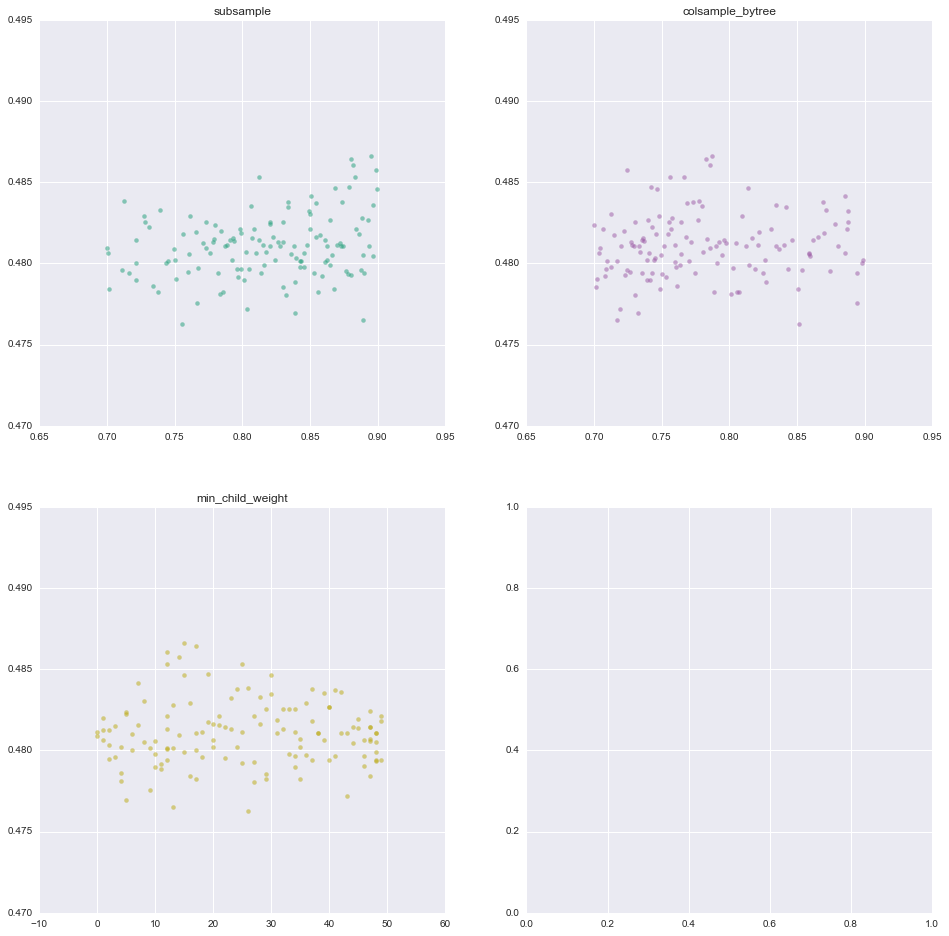

In [16]:
par_values = {'max_depth': range(8,21)}
parameters = trials.trials[0]['misc']['vals'].keys()
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
cmap = plt.cm.Dark2
par_best_score = {}
df = pd.DataFrame(columns=parameters + ['train_auc','val_auc'])
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    val_auc = [1-t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    train_auc = [t['result']['train_score'] for t in trials.trials if 'train_score' in t['result']]
    best_iter = [t['result']['best_iter'] for t in trials.trials if 'best_iter' in t['result']]
    mcc = [t['result']['mcc'] for t in trials.trials if 'mcc' in t['result']]
    tr = [t['result']['threshold'] for t in trials.trials if 'threshold' in t['result']]
    
    df[val] = xs
    df['val_auc'] = val_auc
    df['train_auc'] = train_auc
    df['best_iter'] = best_iter
    df['threshold'] = tr
    df['mcc'] = mcc
    
    
    par_best_score[val] = xs[val_auc.index(min(val_auc))]
    #print trials.trials[ys.index(max(ys))]
    #print i, val, max(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    axes[i/2,i%2].scatter(xs, mcc, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/2,i%2].set_title(val)
print par_best_score
df['diffs'] = df['train_auc'] - df['val_auc']



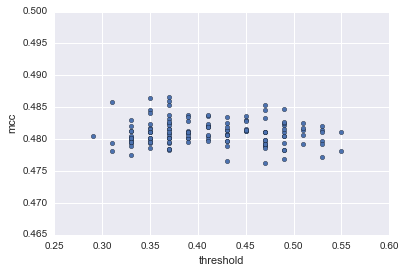

In [17]:
ax = df.plot.scatter('threshold','mcc')
#ax.set_xlim([0.921, 0.926])

(0.924, 0.928)

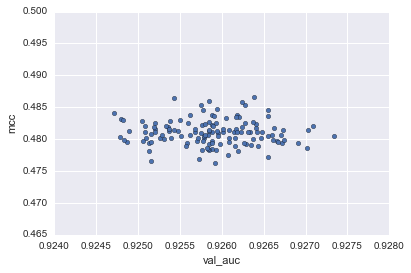

In [19]:
ax = df.plot.scatter('val_auc','mcc')
ax.set_xlim([0.924, 0.928])

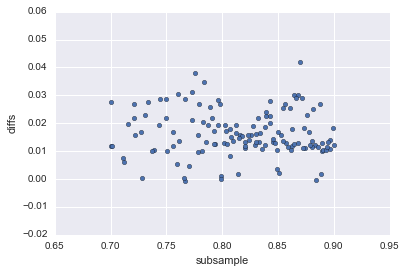

In [22]:
ax = df.plot.scatter('subsample','diffs')
#ax.set_xlim([0.924, 0.928])

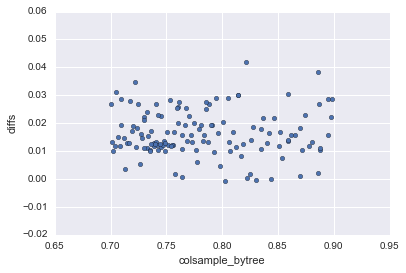

In [23]:
ax = df.plot.scatter('colsample_bytree','diffs')


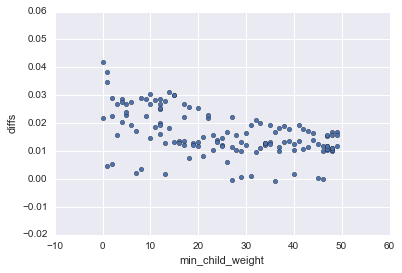

In [24]:
ax = df.plot.scatter('min_child_weight','diffs')


In [25]:
df.sort_values('mcc', ascending=False)

,subsample,colsample_bytree,min_child_weight,train_auc,val_auc,best_iter,threshold,mcc,diffs
120,0.895085,0.786997,15,0.939548,0.926382,48,0.37,0.486593,0.013166
130,0.880313,0.783069,17,0.939069,0.925431,48,0.35,0.486413,0.013638
75,0.881585,0.785355,12,0.951036,0.925846,69,0.37,0.486052,0.025190
79,0.899020,0.724160,14,0.944426,0.926235,58,0.31,0.485772,0.018191
56,0.812120,0.766352,12,0.945547,0.926282,60,0.37,0.485350,0.019265
18,0.883477,0.755889,25,0.937977,0.925750,47,0.47,0.485346,0.012227
107,0.878744,0.742034,19,0.938234,0.925939,47,0.49,0.484729,0.012295
41,0.868346,0.814026,15,0.956644,0.926550,86,0.35,0.484634,0.030094
99,0.899894,0.746819,30,0.937995,0.925775,48,0.47,0.484619,0.012220
46,0.851005,0.885558,7,0.926866,0.924712,28,0.35,0.484173,0.002154


In [66]:
#df.drop(['gamma'], axis=1, inplace=True)
#df.to_csv('./data/xgboost_hyperopt_1fold_100iter.csv', index=False)

In [122]:
df['colsample_bytree'] = df['colsample_bytree'].round(2)

In [127]:
df.sort_values('val_auc', ascending=False)

,colsample_bytree,min_child_weight,train_auc,val_auc,best_iter,diffs
18,0.73,49,0.943012,0.924580,92,0.018432
2,0.70,29,0.947958,0.924540,98,0.023418
61,0.72,49,0.942023,0.924430,93,0.017593
26,0.72,49,0.942023,0.924430,93,0.017593
47,0.73,47,0.943834,0.924389,101,0.019445
75,0.73,30,0.947750,0.924377,96,0.023373
14,0.73,30,0.947750,0.924377,96,0.023373
43,0.74,37,0.945657,0.924363,96,0.021294
73,0.70,49,0.943502,0.924312,98,0.019190
71,0.71,25,0.952072,0.924288,107,0.027784


In [78]:
df.head()

,subsample,colsample_bytree,gamma,min_child_weight,train_auc,val_auc,diffs
0,0.919647,0.734544,28,2,0.922576,0.918840,0.003736
1,0.860606,0.728616,7,17,0.947655,0.921702,0.025953
2,0.900673,0.731379,23,34,0.922294,0.919387,0.002907
3,0.860517,0.704370,1,10,0.947460,0.920868,0.026592
4,0.902383,0.709298,28,34,0.919536,0.918013,0.001523


In [79]:
df['subsample'] = df['subsample'].round(2)
df['colsample_bytree'] = df['colsample_bytree'].round(2)

In [80]:
def plot_scores_for_pars(par):
    f, ax = plt.subplots(1,3, figsize=(16,6), sharex=True)

    df.groupby(par)['val_auc'].mean().plot(ax=ax[0])
    df.groupby(par)['train_auc'].mean().plot(ax=ax[1])
    df.groupby(par)['diffs'].mean().plot(ax=ax[2])

    ax[0].set_ylabel('Test auc')
    ax[1].set_ylabel('Train auc')
    ax[2].set_ylabel('Difference')

    ax[0].set_xlabel(par)
    ax[1].set_xlabel(par)
    ax[2].set_xlabel(par)

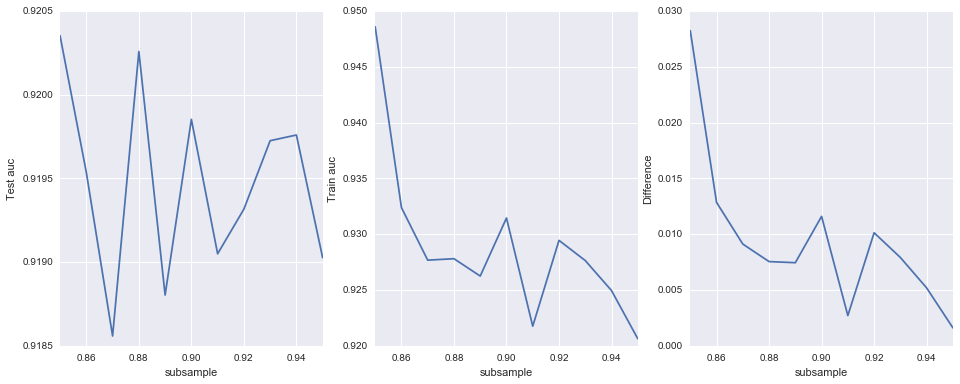

In [81]:
plot_scores_for_pars('subsample')

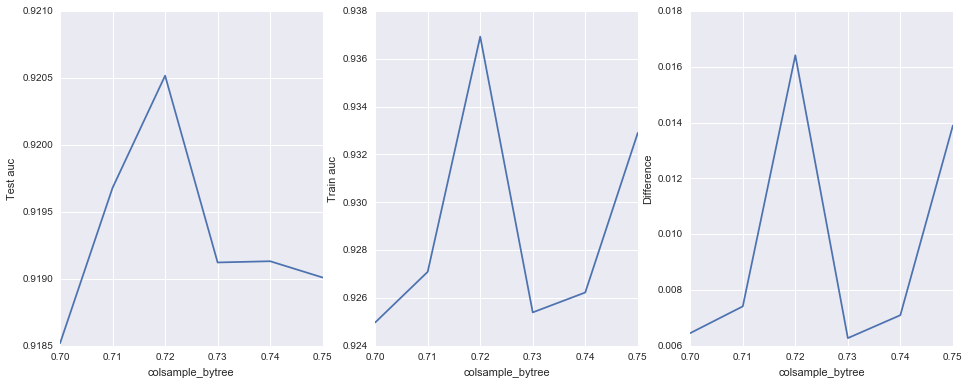

In [82]:
plot_scores_for_pars('colsample_bytree')

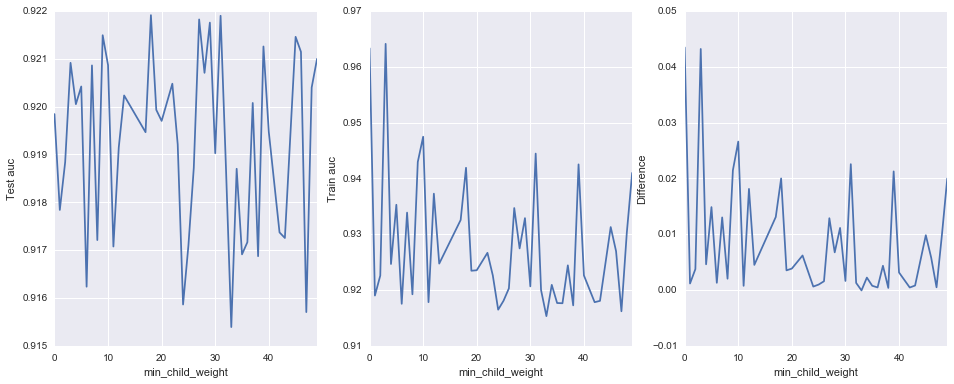

In [85]:
plot_scores_for_pars('min_child_weight')

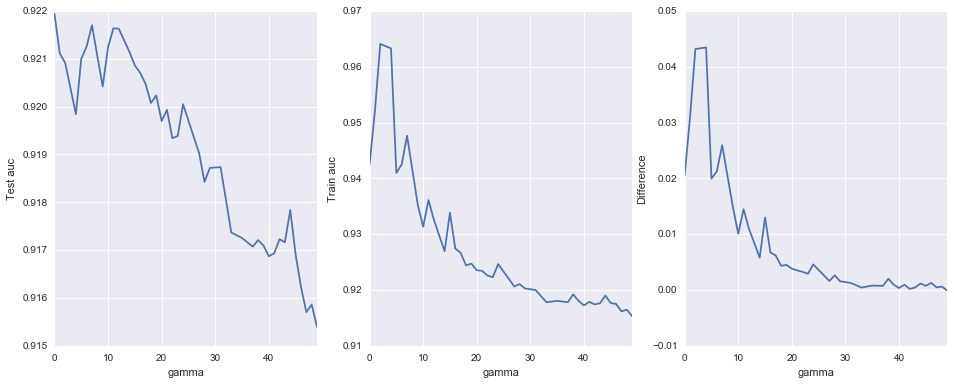

In [84]:
plot_scores_for_pars('gamma')

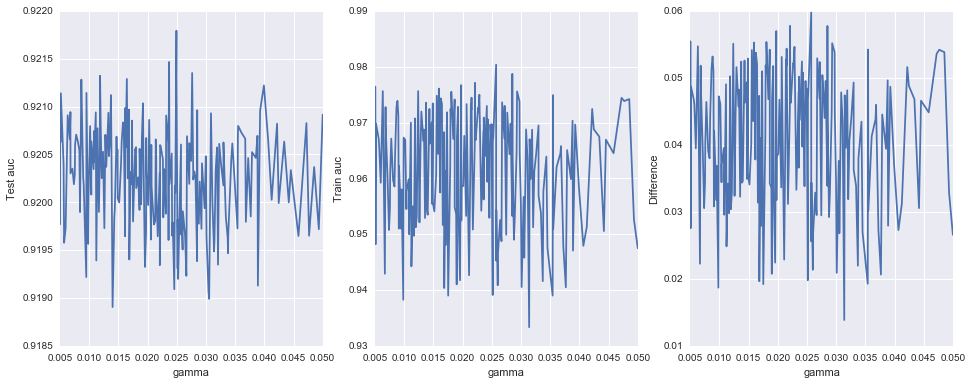

In [64]:
plot_scores_for_pars('gamma')

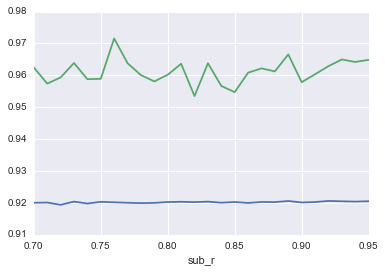

In [42]:
df.groupby('sub_r')['val_auc'].mean().plot()
df.groupby('sub_r')['train_auc'].mean().plot()

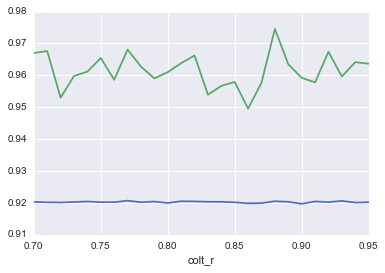

In [44]:
df.groupby('colt_r')['val_auc'].mean().plot()
df.groupby('colt_r')['train_auc'].mean().plot()

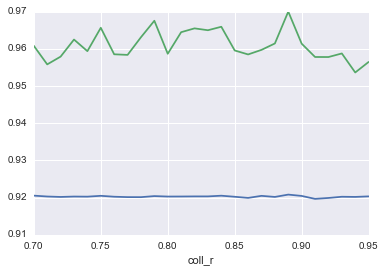

In [45]:
df.groupby('coll_r')['val_auc'].mean().plot()
df.groupby('coll_r')['train_auc'].mean().plot()

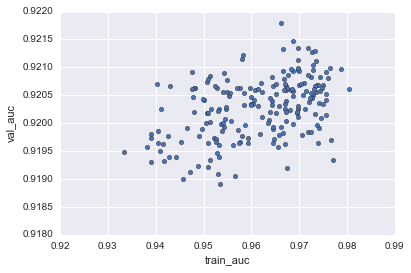

In [24]:
df.plot('train_auc', 'val_auc',kind='scatter', ylim=[0.918, 0.922])

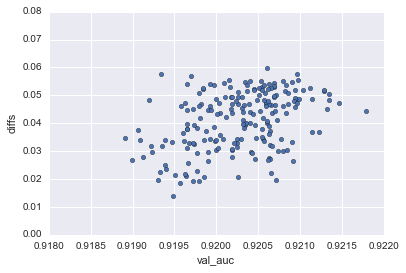

In [29]:
df.plot('val_auc', 'diffs', kind='scatter', xlim=[0.918, 0.922])

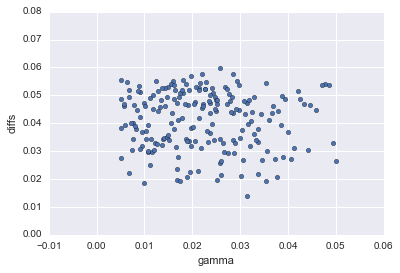

In [20]:
df.plot('gamma', 'diffs',kind='scatter')

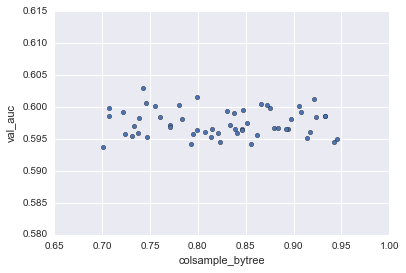

In [44]:
df.plot.scatter('colsample_bytree', 'val_auc', by='max_depth')